# Pong

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/opt/conda/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode    0 | Avg Reward: -20.00 | Loss: 0.0000
Episode   10 | Avg Reward: -20.10 | Loss: 0.0216
Episode   20 | Avg Reward: -20.60 | Loss: 0.0257
Episode   30 | Avg Reward: -20.70 | Loss: 0.0174
Episode   40 | Avg Reward: -20.70 | Loss: 0.0210
Episode   50 | Avg Reward: -20.60 | Loss: 0.0162
Episode   60 | Avg Reward: -20.70 | Loss: 0.0117
Episode   70 | Avg Reward: -20.60 | Loss: 0.0087
Episode   80 | Avg Reward: -20.10 | Loss: 0.0081
Episode   90 | Avg Reward: -20.30 | Loss: 0.0090
Episode  100 | Avg Reward: -20.40 | Loss: 0.0100
Episode  110 | Avg Reward: -20.50 | Loss: 0.0083
Episode  120 | Avg Reward: -20.50 | Loss: 0.0094
Episode  130 | Avg Reward: -20.60 | Loss: 0.0067
Episode  140 | Avg Reward: -20.20 | Loss: 0.0078
Episode  150 | Avg Reward: -20.10 | Loss: 0.0064
Episode  160 | Avg Reward: -20.00 | Loss: 0.0059
Episode  170 | Avg Reward: -20.70 | Loss: 0.0068
Episode  180 | Avg Reward: -20.50 | Loss: 0.0067
Episode  190 | Avg Reward: -20.60 | Loss: 0.0075
Episode  200 | Avg R

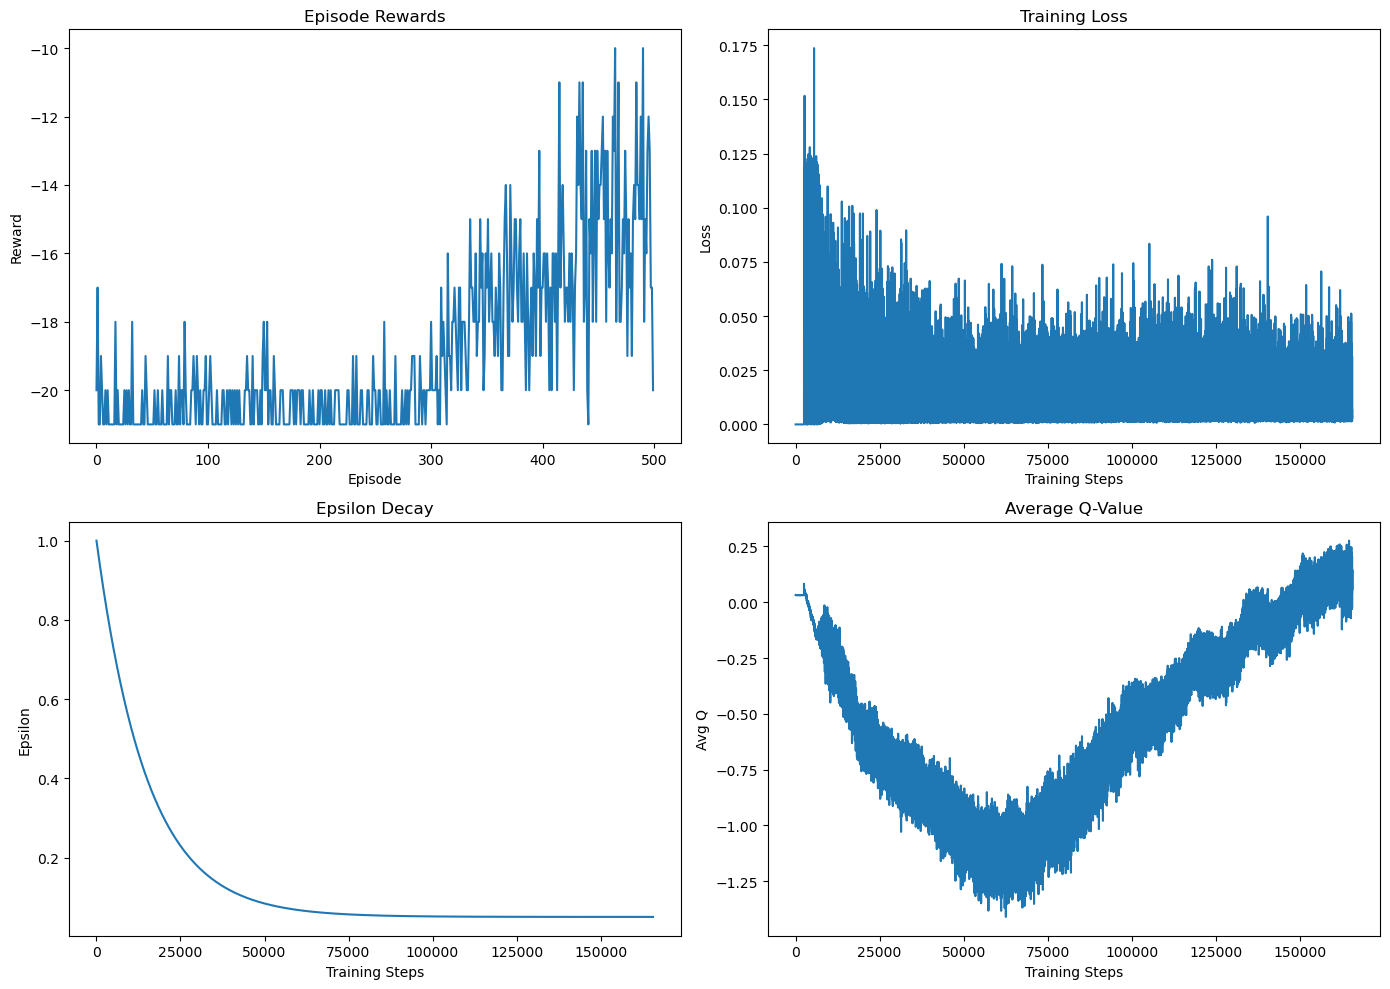

In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
from torch.utils.tensorboard import SummaryWriter
import os
from matplotlib import pyplot as plt
from gym.wrappers import RecordVideo
from IPython.display import HTML
import base64
import glob
%matplotlib inline

# Гиперпараметры
BATCH_SIZE = 32
MEMORY_SIZE = 200_000
LEARNING_STARTS = 10_000
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.05
EXPLORATION_FRACTION = 0.3
EPS_DECAY = int(EXPLORATION_FRACTION * MEMORY_SIZE)
TARGET_UPDATE = 1000
LEARNING_RATE = 1e-4
FRAME_STACK = 4
NUM_EPISODES = 500
TRAIN_FREQ = 4
MAX_GRAD_NORM = 10
TENSORBOARD_LOGDIR = "./dqn_pong_improved_tensorboard/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Настройка TensorBoard
os.makedirs(TENSORBOARD_LOGDIR, exist_ok=True)
writer = SummaryWriter(log_dir=TENSORBOARD_LOGDIR)

# Инициализация среды для Pong
env = gym.make('ALE/Pong-v5',
               obs_type='rgb',
               frameskip=4,
               repeat_action_probability=0.25,
               render_mode='rgb_array')
env = gym.wrappers.ResizeObservation(env, (84, 84))
env = gym.wrappers.GrayScaleObservation(env)
env = gym.wrappers.FrameStack(env, FRAME_STACK)

# DQN модель
class DQN(nn.Module):
    def __init__(self, n_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(FRAME_STACK, 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        self.fc1 = nn.Linear(3136, 512)
        self.out = nn.Linear(512, n_actions)

    def forward(self, x):
        x = x.float() / 255.0
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.out(x)

# Буфер повторов
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, size):
        return random.sample(self.buffer, size)

    def __len__(self):
        return len(self.buffer)

n_actions = env.action_space.n
policy_net = DQN(n_actions).to(device)
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(MEMORY_SIZE)
steps_done = 0

# Дополнительные массивы для логирования
eps_history = []
q_value_history = []

def process_frame(frame):
    frame = np.array(frame)
    return torch.from_numpy(frame).unsqueeze(0).to(device)

def select_action(state):
    global steps_done
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-steps_done / EPS_DECAY)
    steps_done += 1
    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(state).argmax(dim=1, keepdim=True)
    else:
        return torch.tensor([[env.action_space.sample()]], dtype=torch.long, device=device)

def optimize():
    if len(memory) < BATCH_SIZE or steps_done < LEARNING_STARTS:
        return 0.0

    transitions = memory.sample(BATCH_SIZE)
    batch = list(zip(*transitions))

    states = torch.cat(batch[0])
    actions = torch.cat(batch[1])
    rewards = torch.cat(batch[2])
    dones = torch.cat(batch[4])

    non_final_mask = torch.tensor([s is not None for s in batch[3]], device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch[3] if s is not None]) if any(non_final_mask) else None

    current_q = policy_net(states).gather(1, actions)

    next_q = torch.zeros(BATCH_SIZE, device=device)
    if non_final_next_states is not None:
        next_q[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    target_q = rewards + (1.0 - dones) * GAMMA * next_q
    loss = F.mse_loss(current_q.squeeze(), target_q)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), MAX_GRAD_NORM)
    optimizer.step()

    return loss.item()

# Основной цикл обучения
episode_rewards = []
loss_history = []

for episode in range(NUM_EPISODES):
    obs, _ = env.reset()
    state = process_frame(obs)
    total_reward = 0
    done = False

    while not done:
        action = select_action(state)
        next_obs, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        total_reward += reward

        next_state = process_frame(next_obs) if not done else None

        memory.push(state,
                    action,
                    torch.tensor([reward], dtype=torch.float32, device=device),
                    next_state,
                    torch.tensor([done], dtype=torch.float32, device=device))

        state = next_state if next_state is not None else state

        if steps_done % TRAIN_FREQ == 0:
            loss = optimize()
            loss_history.append(loss)
            writer.add_scalar("Loss", loss, steps_done)

            eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-steps_done / EPS_DECAY)
            writer.add_scalar("Epsilon", eps_threshold, steps_done)
            eps_history.append(eps_threshold)

            if len(memory) >= BATCH_SIZE:
                sample_transitions = memory.sample(BATCH_SIZE)
                sample_states = torch.cat([s for (s, _, _, _, _) in sample_transitions])
                with torch.no_grad():
                    q_values = policy_net(sample_states)
                avg_q = q_values.max(1)[0].mean().item()
                writer.add_scalar("Avg_Q", avg_q, steps_done)
                q_value_history.append(avg_q)

        if steps_done % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

    episode_rewards.append(total_reward)
    writer.add_scalar("Reward", total_reward, episode)

    if episode % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:])
        avg_loss = np.mean(loss_history[-100:]) if loss_history else 0
        print(f"Episode {episode:4d} | Avg Reward: {avg_reward:6.2f} | Loss: {avg_loss:6.4f}")

# Сохранение модели
torch.save(policy_net.state_dict(), "dqn_pong_improved.pth")


# Построение графиков
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].set_title("Episode Rewards")
axs[0, 0].plot(episode_rewards)
axs[0, 0].set_xlabel("Episode")
axs[0, 0].set_ylabel("Reward")

axs[0, 1].set_title("Training Loss")
axs[0, 1].plot(loss_history)
axs[0, 1].set_xlabel("Training Steps")
axs[0, 1].set_ylabel("Loss")

axs[1, 0].set_title("Epsilon Decay")
axs[1, 0].plot(eps_history)
axs[1, 0].set_xlabel("Training Steps")
axs[1, 0].set_ylabel("Epsilon")

axs[1, 1].set_title("Average Q-Value")
axs[1, 1].plot(q_value_history)
axs[1, 1].set_xlabel("Training Steps")
axs[1, 1].set_ylabel("Avg Q")

plt.tight_layout()
plt.show()

env.close()
writer.close()




## Демонстрация видео

In [2]:
# Создаём новую среду с записью видео
video_folder = "./video_pong"
os.makedirs(video_folder, exist_ok=True)
demo_env = gym.make('ALE/Pong-v5',
                    obs_type='rgb',
                    frameskip=4,
                    repeat_action_probability=0.25,
                    render_mode='rgb_array')
demo_env = gym.wrappers.ResizeObservation(demo_env, (84, 84))
demo_env = gym.wrappers.GrayScaleObservation(demo_env)
demo_env = gym.wrappers.FrameStack(demo_env, FRAME_STACK)
demo_env = RecordVideo(demo_env, video_folder=video_folder, episode_trigger=lambda ep: True)

obs, _ = demo_env.reset()
done = False
while not done:
    state = process_frame(obs)
    with torch.no_grad():
        action = policy_net(state).argmax(dim=1, keepdim=True)
    obs, reward, terminated, truncated, _ = demo_env.step(action.item())
    done = terminated or truncated
demo_env.close()

# Функция для отображения видео в Jupyter Notebook
def show_video(video_folder):
    mp4_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    if len(mp4_files) > 0:
        video_path = mp4_files[0]
        video = open(video_path, "rb").read()
        video_encoded = base64.b64encode(video).decode("ascii")
        return HTML(f'<video width="640" height="480" controls><source src="data:video/mp4;base64,{video_encoded}" type="video/mp4"></video>')
    else:
        return "Видео не найдено"

# Отобразим видео
show_video(video_folder)

/opt/conda/lib/python3.11/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /home/jovyan/work/RL/video_pong folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/opt/conda/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/opt/conda/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


MoviePy - Building video /home/jovyan/work/RL/video_pong/rl-video-episode-0.mp4.
MoviePy - Writing video /home/jovyan/work/RL/video_pong/rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /home/jovyan/work/RL/video_pong/rl-video-episode-0.mp4


# Breakout

Episode    0 | Avg Reward:   1.00 | Loss: 0.0000
Episode   10 | Avg Reward:   1.10 | Loss: 0.0000
Episode   20 | Avg Reward:   1.60 | Loss: 0.0000
Episode   30 | Avg Reward:   0.90 | Loss: 0.0000
Episode   40 | Avg Reward:   0.90 | Loss: 0.0000
Episode   50 | Avg Reward:   1.00 | Loss: 0.0000
Episode   60 | Avg Reward:   1.30 | Loss: 0.0063
Episode   70 | Avg Reward:   2.10 | Loss: 0.0075
Episode   80 | Avg Reward:   1.50 | Loss: 0.0054
Episode   90 | Avg Reward:   1.10 | Loss: 0.0051
Episode  100 | Avg Reward:   1.20 | Loss: 0.0082
Episode  110 | Avg Reward:   0.80 | Loss: 0.0063
Episode  120 | Avg Reward:   1.30 | Loss: 0.0034
Episode  130 | Avg Reward:   2.80 | Loss: 0.0040
Episode  140 | Avg Reward:   1.10 | Loss: 0.0087
Episode  150 | Avg Reward:   2.30 | Loss: 0.0032
Episode  160 | Avg Reward:   1.40 | Loss: 0.0058
Episode  170 | Avg Reward:   1.90 | Loss: 0.0043
Episode  180 | Avg Reward:   1.80 | Loss: 0.0056
Episode  190 | Avg Reward:   1.40 | Loss: 0.0060
Episode  200 | Avg R

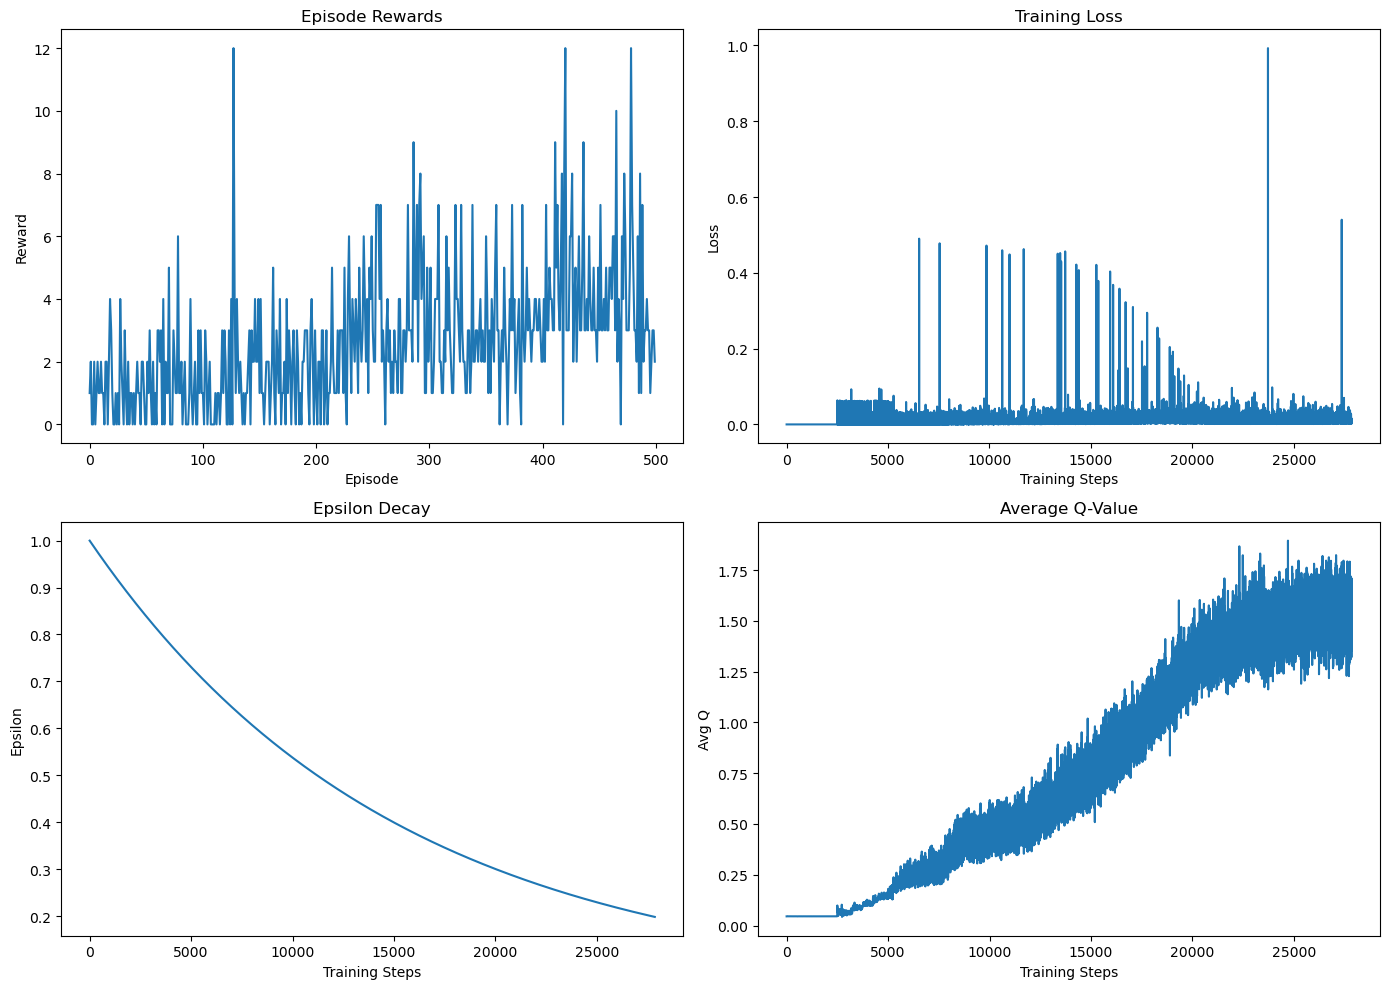

In [3]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
from torch.utils.tensorboard import SummaryWriter
import os
from matplotlib import pyplot as plt
from gym.wrappers import RecordVideo
from IPython.display import HTML
import base64
import glob
%matplotlib inline

# Гиперпараметры
BATCH_SIZE = 32
MEMORY_SIZE = 200_000
LEARNING_STARTS = 10_000
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.05
EXPLORATION_FRACTION = 0.3
EPS_DECAY = int(EXPLORATION_FRACTION * MEMORY_SIZE)
TARGET_UPDATE = 1000
LEARNING_RATE = 1e-4
FRAME_STACK = 4
NUM_EPISODES = 500
TRAIN_FREQ = 4
MAX_GRAD_NORM = 10
TENSORBOARD_LOGDIR = "./dqn_breakout_improved_tensorboard/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Настройка TensorBoard
os.makedirs(TENSORBOARD_LOGDIR, exist_ok=True)
writer = SummaryWriter(log_dir=TENSORBOARD_LOGDIR)

# Инициализация среды для Breakout
env = gym.make('ALE/Breakout-v5',
               obs_type='rgb',
               frameskip=4,
               repeat_action_probability=0.25,
               render_mode='rgb_array')
env = gym.wrappers.ResizeObservation(env, (84, 84))
env = gym.wrappers.GrayScaleObservation(env)
env = gym.wrappers.FrameStack(env, FRAME_STACK)

# DQN модель
class DQN(nn.Module):
    def __init__(self, n_actions):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(FRAME_STACK, 32, 8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
        self.fc1 = nn.Linear(3136, 512)
        self.out = nn.Linear(512, n_actions)

    def forward(self, x):
        x = x.float() / 255.0
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.out(x)

# Буфер повторов
class ReplayMemory:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, size):
        return random.sample(self.buffer, size)

    def __len__(self):
        return len(self.buffer)

n_actions = env.action_space.n
policy_net = DQN(n_actions).to(device)
target_net = DQN(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(MEMORY_SIZE)
steps_done = 0

# Дополнительные массивы для логирования
eps_history = []
q_value_history = []

def process_frame(frame):
    frame = np.array(frame)
    return torch.from_numpy(frame).unsqueeze(0).to(device)

def select_action(state):
    global steps_done
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-steps_done / EPS_DECAY)
    steps_done += 1
    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(state).argmax(dim=1, keepdim=True)
    else:
        return torch.tensor([[env.action_space.sample()]], dtype=torch.long, device=device)

def optimize():
    if len(memory) < BATCH_SIZE or steps_done < LEARNING_STARTS:
        return 0.0

    transitions = memory.sample(BATCH_SIZE)
    batch = list(zip(*transitions))

    states = torch.cat(batch[0])
    actions = torch.cat(batch[1])
    rewards = torch.cat(batch[2])
    dones = torch.cat(batch[4])

    non_final_mask = torch.tensor([s is not None for s in batch[3]], device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch[3] if s is not None]) if any(non_final_mask) else None

    current_q = policy_net(states).gather(1, actions)

    next_q = torch.zeros(BATCH_SIZE, device=device)
    if non_final_next_states is not None:
        next_q[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    target_q = rewards + (1.0 - dones) * GAMMA * next_q
    loss = F.mse_loss(current_q.squeeze(), target_q)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), MAX_GRAD_NORM)
    optimizer.step()

    return loss.item()

# Основной цикл обучения
episode_rewards = []
loss_history = []

for episode in range(NUM_EPISODES):
    obs, _ = env.reset()
    state = process_frame(obs)
    total_reward = 0
    done = False

    while not done:
        action = select_action(state)
        next_obs, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated
        total_reward += reward

        next_state = process_frame(next_obs) if not done else None

        memory.push(state,
                    action,
                    torch.tensor([reward], dtype=torch.float32, device=device),
                    next_state,
                    torch.tensor([done], dtype=torch.float32, device=device))

        state = next_state if next_state is not None else state

        if steps_done % TRAIN_FREQ == 0:
            loss = optimize()
            loss_history.append(loss)
            writer.add_scalar("Loss", loss, steps_done)

            eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-steps_done / EPS_DECAY)
            writer.add_scalar("Epsilon", eps_threshold, steps_done)
            eps_history.append(eps_threshold)

            if len(memory) >= BATCH_SIZE:
                sample_transitions = memory.sample(BATCH_SIZE)
                sample_states = torch.cat([s for (s, _, _, _, _) in sample_transitions])
                with torch.no_grad():
                    q_values = policy_net(sample_states)
                avg_q = q_values.max(1)[0].mean().item()
                writer.add_scalar("Avg_Q", avg_q, steps_done)
                q_value_history.append(avg_q)

        if steps_done % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

    episode_rewards.append(total_reward)
    writer.add_scalar("Reward", total_reward, episode)

    if episode % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:])
        avg_loss = np.mean(loss_history[-100:]) if loss_history else 0
        print(f"Episode {episode:4d} | Avg Reward: {avg_reward:6.2f} | Loss: {avg_loss:6.4f}")

# Сохранение модели
torch.save(policy_net.state_dict(), "dqn_breakout_improved.pth")


# Построение графиков
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

axs[0, 0].set_title("Episode Rewards")
axs[0, 0].plot(episode_rewards)
axs[0, 0].set_xlabel("Episode")
axs[0, 0].set_ylabel("Reward")

axs[0, 1].set_title("Training Loss")
axs[0, 1].plot(loss_history)
axs[0, 1].set_xlabel("Training Steps")
axs[0, 1].set_ylabel("Loss")

axs[1, 0].set_title("Epsilon Decay")
axs[1, 0].plot(eps_history)
axs[1, 0].set_xlabel("Training Steps")
axs[1, 0].set_ylabel("Epsilon")

axs[1, 1].set_title("Average Q-Value")
axs[1, 1].plot(q_value_history)
axs[1, 1].set_xlabel("Training Steps")
axs[1, 1].set_ylabel("Avg Q")

plt.tight_layout()
plt.show()


env.close()
writer.close()



## Демонстрация видео

In [4]:
# Демонстрация видео для Breakout
video_folder = "./video_breakout"
os.makedirs(video_folder, exist_ok=True)
demo_env = gym.make('ALE/Breakout-v5',
                    obs_type='rgb',
                    frameskip=4,
                    repeat_action_probability=0.25,
                    render_mode='rgb_array')
demo_env = gym.wrappers.ResizeObservation(demo_env, (84, 84))
demo_env = gym.wrappers.GrayScaleObservation(demo_env)
demo_env = gym.wrappers.FrameStack(demo_env, FRAME_STACK)
demo_env = RecordVideo(demo_env, video_folder=video_folder, episode_trigger=lambda ep: True)

obs, _ = demo_env.reset()
done = False
while not done:
    state = process_frame(obs)
    with torch.no_grad():
        action = policy_net(state).argmax(dim=1, keepdim=True)
    obs, reward, terminated, truncated, _ = demo_env.step(action.item())
    done = terminated or truncated
demo_env.close()

# Функция для отображения видео в Jupyter Notebook
def show_video(video_folder):
    mp4_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    if len(mp4_files) > 0:
        video_path = mp4_files[0]
        video = open(video_path, "rb").read()
        video_encoded = base64.b64encode(video).decode("ascii")
        return HTML(f'<video width="640" height="480" controls><source src="data:video/mp4;base64,{video_encoded}" type="video/mp4"></video>')
    else:
        return "Видео не найдено"

# Отобразим видео для Breakout
show_video(video_folder)

/opt/conda/lib/python3.11/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /home/jovyan/work/RL/video_breakout folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


MoviePy - Building video /home/jovyan/work/RL/video_breakout/rl-video-episode-0.mp4.
MoviePy - Writing video /home/jovyan/work/RL/video_breakout/rl-video-episode-0.mp4



MoviePy - Done !
MoviePy - video ready /home/jovyan/work/RL/video_breakout/rl-video-episode-0.mp4
